In [123]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from math import exp
import seaborn as sns
#from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss

In [124]:
data=pd.read_csv('train_pp.csv')
X=data.drop('Survived',axis=1).to_numpy()
y=data['Survived'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=25)

In [125]:
X_train.shape

(801, 7)

In [126]:
class BPNN:
    def __init__(self,X,y,lr):
        self.inp=X
        self.wts=[np.random.rand(self.inp.shape[1],128),
                  np.random.rand(128,64),
                  np.random.rand(64,32),
                  np.random.rand(32,16),
                  np.random.rand(16,1)]
        self.base=[np.zeros((1,128)),
                   np.zeros((1,64)),
                   np.zeros((1,32)),
                   np.zeros((1,16)),
                   np.zeros((1,1))]
        self.gamma=[np.ones((1,128)),
                   np.ones((1,64)),
                   np.ones((1,32)),
                   np.ones((1,16))]
        self.beta=[np.zeros((1,128)),
                   np.zeros((1,64)),
                   np.zeros((1,32)),
                   np.zeros((1,16))]
        
        self.lr=lr
        self.target=y
        self.layers=len(self.wts)-1
        self.total_loss=list()

    def batchnorm_forward(self,x, gamma, beta, eps=1e-5):
        N, D = x.shape
        sample_mean = np.mean(x,axis=0)
        sample_var = np.var(x,axis=0)
        std = np.sqrt(sample_var + eps)
        x_centered = x - sample_mean
        x_norm = x_centered / std
        out = (gamma * x_norm) + beta
        cache = (x_norm, x_centered, std, gamma)
        return out, cache
    
    #FeedForward
    def FF(self,xin,a,z,cache):
        for i in range(self.layers+1):
            z[i]=np.matmul(xin,self.wts[i])+self.base[i]
            
            '''if i reaches the output layer, then sigmoid function will get applied instead  of relu'''
            if i==self.layers:
                a[i]=self.sigmoid(z[i])
            else:
                '''batch normalizing z here and storing cache value for a specific batch for all hidden layers,
                gamma and beta will get updated based on this cache'''
                z[i],cache[i]=self.batchnorm_forward(z[i],self.gamma[i],self.beta[i])
                a[i]=self.relu(z[i])
                
            '''setting up input for the next layer'''
            xin=a[i]
        return a,z,cache
    
    def loss(self,y_net,y_cap,batch):
        
        '''y_net is predicted y, since loss function is not valid for y_net==1 or 0
        therefore clipping it with eps
        This function return error with shape(1,batch)'''
        eps=1e-15
        y_net=np.maximum(eps,np.minimum(1-eps,y_net))
        e=-((y_cap)*np.log(y_net)+(1-y_cap)*np.log(1-y_net))/batch
        return e
        
    def get_loss(self):
        return self.total_loss
        
    def BP(self,e,delta,z):
        
        '''updating delta'''
        for i in range(self.layers-1,-1,-1):
            delta[i]=self.df_relu(z[i])*np.matmul(e,self.wts[i+1].T)            
            e=delta[i]
        return delta
    
    def batchnorm_backward(self,dout, cache):
        N = dout.shape[0]
        x_norm, x_centered, std, gamma = cache
        dgamma = np.sum((dout * x_norm),axis=0,keepdims=True)
        dbeta = np.sum(dout,axis=0,keepdims=True)
        dx_norm = dout * gamma
        dx_centered = dx_norm / std
        dmean = -(dx_centered.sum(axis=0) + 2/N * x_centered.sum(axis=0))
        dstd = (dx_norm * x_centered * -std**(-2)).sum(axis=0)
        dvar = dstd / 2 / std
        dx = dx_centered + (dmean + dvar * 2 * x_centered) / N
        return dx, dgamma, dbeta
                    
    def update(self,e,x_cap,a,delta,batch,cache):
        for i in range(self.layers,0,-1):
            
            '''updating weigths and bias here
            both gradients are average, taken for the batch'''
            self.wts[i]-=self.lr*np.matmul(a[i-1].T,e)
            self.base[i]-=self.lr*np.sum(e,axis=0,keepdims=True)
            e=delta[i-1]
            
            '''updating gamma and beta here by doing backpropagation for batch normalization'''
            dx,dgamma,dbeta=self.batchnorm_backward(e,cache[i-1])
            self.gamma[i-1]-=self.lr*dgamma
            self.beta[i-1]-=self.lr*dbeta
            
        '''updating weights and bias for the 1st hidden layer'''
        self.wts[0]-=self.lr*np.matmul(x_cap.T,e)
        self.base[0]-=self.lr*np.sum(e,axis=0,keepdims=True)
        
    def relu(self,x):
        x[x<0]=0
        return x
        
    def df_relu(self,x):
        x[x>=0]=1
        x[x<0]=0
        return x        
        
    def sigmoid(self,x):
        return 1/(1+np.exp(-x))
       
    
    def df_sigmoid(self,x):
        return self.sigmoid(x)*(1-self.sigmoid(x))    
    
    def train(self, epoch=20, batch=32):
        for i in range(epoch):
            print('------------------------------------')
            print(f'epoch: {i+1}/{epoch}')
            
            '''a,z,cache and delta will get initialized everytime for a new epoch'''
            loss_per_epo=list()
            a=[0]*(self.layers+1)
            z=[0]*(self.layers+1)
            delta=[0]*(self.layers)
            cache=[0]*(self.layers)
            
            '''providing input for 1 batch in 1 loop iteration'''
            for j in range(0,self.inp.shape[0],batch):
                x_cap=self.inp[j:j+batch]
                y_cap=self.target[j:j+batch].reshape(len(self.target[j:j+batch]),1)
                a,z,cache=self.FF(x_cap,a,z,cache)
                error=self.loss(a[-1],y_cap,batch)
                loss_per_epo.append(sum(error))
                delta=self.BP(error,delta,z)
                self.update(error,x_cap,a,delta,batch,cache)
#                 print(f'error:{np.concatenate((a[-1],y_cap,x_cap),axis=1),error}')

            '''calculating loss over an epoch in loss_avg to plot it'''
            loss_avg=sum(loss_per_epo)/(self.inp.shape[0]//batch)
            self.total_loss.append(loss_avg)
            print(f'loss: {loss_avg}')

In [127]:
#Backpropogation
cyc=100
BP_nn=BPNN(X_train,y_train,lr=0.00001)

In [128]:
arr = np.array([[1,2,-1000]])
BP_nn.relu(arr)

array([[1, 2, 0]])

In [129]:
BP_nn.train(epoch=cyc)

------------------------------------
epoch: 1/100
loss: [1.46131726]
------------------------------------
epoch: 2/100
loss: [0.92192737]
------------------------------------
epoch: 3/100
loss: [0.69306708]
------------------------------------
epoch: 4/100
loss: [0.69391348]
------------------------------------
epoch: 5/100
loss: [0.69389303]
------------------------------------
epoch: 6/100
loss: [0.69387259]
------------------------------------
epoch: 7/100
loss: [0.69385215]
------------------------------------
epoch: 8/100
loss: [0.69383173]
------------------------------------
epoch: 9/100
loss: [0.69381131]
------------------------------------
epoch: 10/100
loss: [0.6937909]
------------------------------------
epoch: 11/100
loss: [0.69377049]
------------------------------------
epoch: 12/100
loss: [0.6937501]
------------------------------------
epoch: 13/100
loss: [0.69372971]
------------------------------------
epoch: 14/100
loss: [0.69370934]
-------------------------------

In [130]:
loss_train = BP_nn.get_loss()

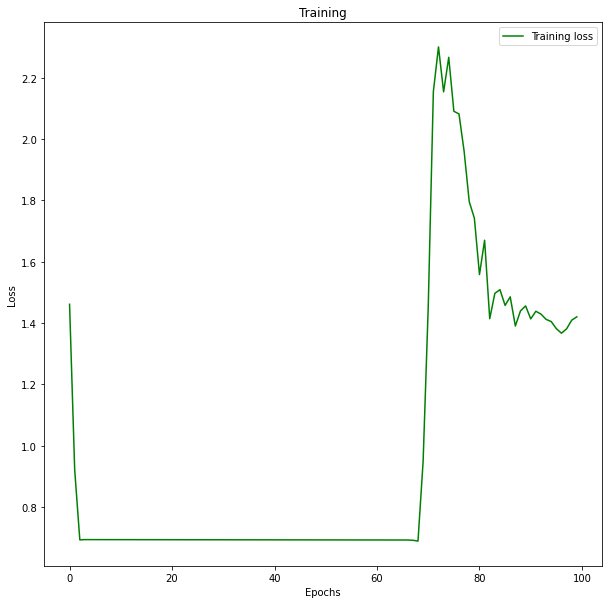

In [131]:
plt.figure(figsize=(10,10))
plt.plot(range(cyc), loss_train, 'g', label='Training loss')
plt.title('Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [132]:
class DFANN_IMP:
    def __init__(self,X,y,lr):
        self.inp=X
        self.wts=[np.random.rand(self.inp.shape[1],3),
                  np.random.rand(3,2),
                  np.random.rand(2,1)]
        self.lr=lr
        self.y=y
        self.layers=len(self.wts)-1
        self.total_loss=list()
        self.z=[0,0,0]
        self.a=[0,0,0]
        self.delta=[np.zeros((self.inp.shape[0],3)),np.zeros((self.inp.shape[0],2))]
        self.bp_flag=1
        
#         self.w1=np.random.rand(self.inp.shape[1],3)
#         self.w2=np.random.rand(3,2)
#         self.w3=np.random.rand(2,1)
#         self.b1=np.zeros((1,3))
#         self.b2=np.zeros(2)
#         self.b3=np.zeros(1)
#         self.B3=np.random.rand(2,1)
#         self.B2=np.random.rand(3,1)
    
    def FF(self):
        xin=self.inp
        for i in range(self.layers+1):
            self.z[i]=np.matmul(xin,self.wts[i])
            self.a[i]=self.f_sigmoid(self.z[i])
            xin=self.a[i]
        
        # self.a[2] will be the final output *************************
        
#         self.z1=np.matmul(self.inp,self.w1)
#         self.a1=self.f_sigmoid(self.z1)
        
#         self.z2=np.matmul(self.a1,self.w2)
#         self.a2=self.f_sigmoid(self.z2)
        
#         self.z3=np.matmul(self.a2,self.w3)
#         self.out=self.f_sigmoid(self.z3)
    
    def loss(self):
        self.e=self.a[2]-self.y
        self.total_loss.append(np.sum(self.e**2))
        
    def get_loss(self):
        return self.total_loss
        
    def BP(self):
        if self.bp_flag==1:
            B=np.random.rand(2,1)
            self.delta[1]=self.df_sigmoid(self.z[1])*np.matmul(self.e,B.T)
            self.bp_flag=0
        else:
            B=np.random.rand(3,1)
            self.delta[0]=self.df_sigmoid(self.z[0])*np.matmul(self.e,B.T)
            self.bp_flag=1
            
#         self.d2=self.df_sigmoid(self.z2)*np.matmul(self.e,self.B3.T)
#         self.d1=self.df_sigmoid(self.z1)*np.matmul(self.e,self.B2.T)
        
    def update(self):
        self.wts[2]-=self.lr*np.matmul(self.a[1].T,self.e)
        if self.bp_flag==1:
            self.wts[1]-=self.lr*np.matmul(self.a[0].T, self.delta[1])
        else:
#             print(self.inp.T.shape,self.delta[0].shape)
            self.wts[0]-=self.lr*np.matmul(self.inp.T, self.delta[0])
            
#         self.b3 = self.b3-self.lr*self.e
#         self.b2 = self.b2-self.lr*self.d2
#         self.b1 = self.b1-self.lr*self.d1
        
    def f_sigmoid(self,x):
        return 1/(1+np.exp(-x))
    
    def df_sigmoid(self,x):
        return self.f_sigmoid(x)*(1-self.f_sigmoid(x))
    
    def train(self, itr=1000):
        for i in range(itr):
            self.FF()
            self.loss()
            self.BP()
            self.update()
    
    def predict(self,x_test):
        xin=x_test
        for i in range(self.layers+1):
            z_pred=np.matmul(xin,self.wts[i])
            a_pred=self.f_sigmoid(z_pred)
            xin=a_pred
        
        return xin
        
#         z1_pred=np.matmul(x_test,self.w1)
#         a1_pred=self.f_sigmoid(z1_pred)
        
#         z2_pred=np.matmul(a1_pred,self.w2)
#         a2_pred=self.f_sigmoid(z2_pred)
        
#         z3_pred=np.matmul(a2_pred,self.w3)
#         y_pred=self.f_sigmoid(z3_pred)
        
#         return y_pred
    
    def show(self):
        print(f'w1: {self.wts[0].shape}')
        print(f'w2: {self.wts[1].shape}')        
        print(f'w3: {self.wts[2].shape}')        
#         print(f'b1: {self.b1.shape}')        
#         print(f'b2: {self.b2.shape}')        
#         print(f'b2: {self.b3.shape}')        

# DFA

In [133]:
class DFANN:
    def __init__(self,X,y,lr):
        self.inp=X
        self.w1=np.random.rand(self.inp.shape[1],3)
        self.w2=np.random.rand(3,2)
        self.w3=np.random.rand(2,1)
#         self.b1=np.zeros((1,3))
#         self.b2=np.zeros(2)
#         self.b3=np.zeros(1)
        self.lr=lr
        self.y=y
        self.out=np.zeros(y.shape)
        self.l=list()
        self.B3=np.random.rand(2,1)
        self.B2=np.random.rand(3,1)
    
    def FF(self):
        self.z1=np.matmul(self.inp,self.w1)
        self.a1=self.f_sigmoid(self.z1)
        
        self.z2=np.matmul(self.a1,self.w2)
        self.a2=self.f_sigmoid(self.z2)
        
        self.z3=np.matmul(self.a2,self.w3)
        self.out=self.f_sigmoid(self.z3)
    
    def loss(self):
        self.e=self.out-self.y
        self.l.append(np.sum(self.e**2))
        
    def get_loss(self):
        return self.l
        
    def BP(self):
        self.d2=self.df_sigmoid(self.z2)*np.matmul(self.e,self.B3.T)
        self.d1=self.df_sigmoid(self.z1)*np.matmul(self.e,self.B2.T)
        
    def update(self):
        self.w3 = self.w3-self.lr*np.matmul(self.a2.T,self.e)
        self.w2 = self.w2-self.lr*np.matmul(self.a1.T, self.d2)
        self.w1 = self.w1-self.lr*np.matmul(self.inp.T, self.d1)
#         self.b3 = self.b3-self.lr*self.e
#         self.b2 = self.b2-self.lr*self.d2
#         self.b1 = self.b1-self.lr*self.d1
        
    def f_sigmoid(self,x):
        return 1/(1+np.exp(-x))
    
    def df_sigmoid(self,x):
        return self.f_sigmoid(x)*(1-self.f_sigmoid(x))
    
    def train(self, itr=100):
        for i in range(itr):
            self.FF()
            self.loss()
            self.BP()
            self.update()
    
    def predict(self,x_test):
        z1_pred=np.matmul(x_test,self.w1)
        a1_pred=self.f_sigmoid(z1_pred)
        
        z2_pred=np.matmul(a1_pred,self.w2)
        a2_pred=self.f_sigmoid(z2_pred)
        
        z3_pred=np.matmul(a2_pred,self.w3)
        y_pred=self.f_sigmoid(z3_pred)
        
        return y_pred
    
    def show(self):
        print(f'w1: {self.w1.shape}')
        print(f'w2: {self.w2.shape}')        
        print(f'w3: {self.w3.shape}')        
#         print(f'b1: {self.b1.shape}')        
#         print(f'b2: {self.b2.shape}')        
#         print(f'b2: {self.b3.shape}')        

# DFA_newAlgo

# Something good probably

In [134]:
class DFANN_X:
    def __init__(self,X,y,lr):
        self.inp=X
        self.w1=np.random.rand(self.inp.shape[1],3)
        self.w2=np.random.rand(3,2)
        self.w3=np.random.rand(2,1)
#         self.b1=np.zeros((1,3))
#         self.b2=np.zeros(2)
#         self.b3=np.zeros(1)
        self.lr=lr
        self.y=y
        self.out=np.zeros(y.shape)
        self.l=list()
        self.B3=np.random.rand(2,1)
        self.B2=np.random.rand(3,1)
        self.ac=[0,0]
    
    def FF(self):
        self.z1=np.matmul(self.inp,self.w1)
        self.a1=self.f_sigmoid(self.z1)
        
        self.z2=np.matmul(self.a1,self.w2)
        self.a2=self.f_sigmoid(self.z2)
        
        self.z3=np.matmul(self.a2,self.w3)
        self.out=self.f_sigmoid(self.z3)
    
    def loss(self):
        self.e=self.out-self.y
        self.l.append(np.sum(self.e**2))
        
    def get_loss(self):
        return self.l
        
    def BP(self):
        self.w3 = self.w3-self.lr*np.matmul(self.a2.T,self.e)
        if np.sum(self.z2)>np.sum(self.z1):
            self.d2=self.df_sigmoid(self.z2)*np.matmul(self.e,self.B3.T)
            self.w2-=self.lr*np.matmul(self.a1.T, self.d2)
            self.ac[1]+=1
        else:
            self.d1=self.df_sigmoid(self.z1)*np.matmul(self.e,self.B2.T)
            self.w1-=self.lr*np.matmul(self.inp.T, self.d1)
            self.ac[0]+=1
    
    def count_act(self):
        return self.ac
        
#     def update(self):
#         self.w3 = self.w3-self.lr*np.matmul(self.a2.T,self.e)
#         self.w2 = self.w2-self.lr*np.matmul(self.a1.T, self.d2)
#         self.w1 = self.w1-self.lr*np.matmul(self.inp.T, self.d1)
#         self.b3 = self.b3-self.lr*self.e
#         self.b2 = self.b2-self.lr*self.d2
#         self.b1 = self.b1-self.lr*self.d1
        
    def f_sigmoid(self,x):
        return 1/(1+np.exp(-x))
    
    def df_sigmoid(self,x):
        return self.f_sigmoid(x)*(1-self.f_sigmoid(x))
    
    def train(self, itr=100):
        for i in range(itr):
            self.FF()
            self.loss()
            self.BP()
#             self.update()
    
    def predict(self,x_test):
        z1_pred=np.matmul(x_test,self.w1)
        a1_pred=self.f_sigmoid(z1_pred)
        
        z2_pred=np.matmul(a1_pred,self.w2)
        a2_pred=self.f_sigmoid(z2_pred)
        
        z3_pred=np.matmul(a2_pred,self.w3)
        y_pred=self.f_sigmoid(z3_pred)
        
        return y_pred
    
    def show(self):
        print(f'w1: {self.w1.shape}')
        print(f'w2: {self.w2.shape}')        
        print(f'w3: {self.w3.shape}')        
#         print(f'b1: {self.b1.shape}')        
#         print(f'b2: {self.b2.shape}')        
#         print(f'b2: {self.b3.shape}')        

In [135]:
# data = {'x1':[0, 0, 1, 0],
#         'x2':[0, 1, 1, 1],
#         'x3':[1, 0, 1, 1],
#         'y':[1, 1, 1, 0]}
# df = pd.DataFrame(data)

# X_train = df.iloc[:,:3].to_numpy()
# y_train = df.iloc[:,3:4].to_numpy()

In [136]:
# train_data=pd.read_csv('Data/train.csv')
# ind=np.random.randint(0,371,100)
# train_data=train_data.iloc[ind,:]
# train_data.shape

In [137]:
# X=train_data[['bone_length','rotting_flesh','hair_length','has_soul']].to_numpy()
# y=train_data['type'].to_numpy()
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=25, test_size=0.25)
# y_train=y_train.reshape(-1,1)
# y_test=y_test.reshape(-1,1)

In [138]:
#Backpropogation
cyc=10
BP_nn=BPNN(X_train,y_train,lr=0.1)

In [139]:
BP_nn.train(itr=cyc)

TypeError: train() got an unexpected keyword argument 'itr'

In [ ]:
loss_train = BP_nn.get_loss()

plt.figure(figsize=(10,10))
plt.plot(range(cyc), loss_train, 'g', label='Training loss')
plt.title('Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
data=pd.read_csv('E:/Reseach/NewAlgo/Data/MNIST/train/train.csv')
data.shape

In [ ]:
#DFA
cyc=10000
DFA_nn=DFANN(X_train,y_train,lr=0.01)
DFA_nn.train(itr=cyc)
loss_train = DFA_nn.get_loss()

plt.figure(figsize=(10,10))
plt.plot(range(cyc), loss_train, 'g', label='Training loss')
plt.title('Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#DFA_newAlgo
cyc=30000
DFA_nn_imp=DFANN_IMP(X_train,y_train,lr=0.05)
DFA_nn_imp.train(itr=cyc)
loss_train = DFA_nn_imp.get_loss()

plt.figure(figsize=(10,10))
plt.plot(range(cyc), loss_train, 'g', label='Training loss')
plt.title('Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#SGP
cyc=10000
DFA_nn_X=DFANN_X(X_train,y_train,lr=0.1)
DFA_nn_X.train(itr=cyc)
loss_train = DFA_nn_X.get_loss()

plt.figure(figsize=(10,10))
plt.plot(range(cyc), loss_train, 'g', label='Training loss')
plt.title('Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
DFA_nn_X.count_act()

In [ ]:
#SGP
cyc=10000
DFA_nn_X=DFANN_X(X_train,y_train,lr=0.1)
DFA_nn_X.train(itr=cyc)
loss_train = DFA_nn_X.get_loss()

plt.figure(figsize=(10,10))
plt.plot(range(cyc), loss_train, 'g', label='Training loss')
plt.title('Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
DFA_nn_X.count_act()

In [ ]:
#Backpropogation
cyc=10000
BP_nn=BPNN(X_train,y_train,lr=0.005)
BP_nn.train(itr=cyc)
loss_train = BP_nn.get_loss()

plt.figure(figsize=(10,10))
plt.plot(range(cyc), loss_train, 'g', label='Training loss')
plt.title('Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()